# A sequential generative model for MNIST

The PixelCNN [1] generates images through the conditional probabilities. The model fits the probability $p(x_i | x_{<i})$.
* During training: we need to from training pairs (x_{<i}, x_i) and use these pairs to train the model.
* During generation, we loop through $i=0, \ldots, d-1$, and generate each pixel $x_i$ through a sample $p(x_i | x_{<i})$.


**Work to complete**:
1. [2 points] create the CNN model. You may want to start with a simple network and then gradually increase its depth/width.
2. [2 points] set up the training loop. Please remember to call the function "form_conditional_samples"
3. [4 points] train the model. After training, please show the test loss in each epoch. The test loss should descent with the training epochs.
4. [2 points] show the generate examples.
5. [5 points] There are two sub-questions below. Please answer these two questions before or after the coding part.


**Extra notes**:
1. Please use LLMs (Gemini associated with the notebook or others) to generate the code for each cell. Free versions of LLMs are sufficient for the work. You can use Claude or GPT by typing the prompts there and copying the code back to the notebook.

2. With your Tufts email, you can apply for GPU computation credits. Please do apply for the credits early.

3. You are reponsible for the correctness of the the code, not the LLM.



[1] Aäron van den Oord, Nal Kalchbrenner, Oriol Vinyals, Lasse Espeholt, Alex Graves, and Koray Kavukcuoglu. 2016. Conditional image generation with PixelCNN decoders. In Proceedings of the 30th International Conference on Neural Information Processing Systems (NIPS'16). Curran Associates Inc., Red Hook, NY, USA, 4797–4805.

**Sub-question 5.1** (2 points). Suppose we want the model to predict $x_i$ at the $i$-th step, why are we so strict about not letting the model using entries after $i$? What's the consequence if we forget to mask out all bits after $i - 1$?

**Answer:**

**Sub-question 5.3** (3 points). Suppose we take a random batch of test instances and select random locations for each test instance to compute a test loss for plotting and monitoring the training progress. Is the test loss an unbiased estimation of the log-likelihood of test instances? Please given an answer and explain your reason. Please remember: our goal is to maximize the log-likelihood of *test* data to avoid overfitting.

**Answer:**

## Download and prepare data

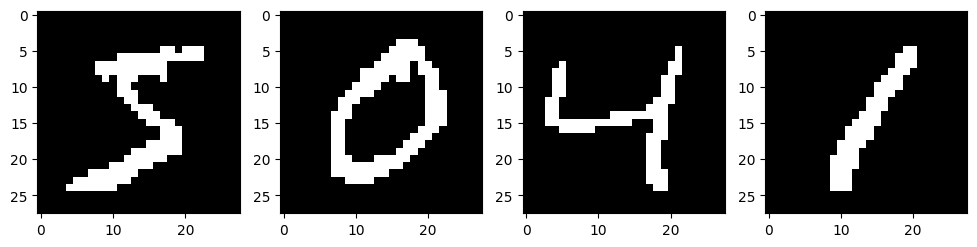

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_images = trainset.data.numpy()
test_images = testset.data.numpy()

# Let's work on the simple case and make mnist binary data

train_images = (train_images > 128).astype(np.float32)
test_images = (test_images > 128).astype(np.float32)

# show a few images from the training set

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
for idx, img in enumerate(train_images[:4]):
    axes[idx].imshow(img, cmap='gray')



## Define the mdoel

In [1]:
# Please create your model here


## Forming random batches

For each instance x, get the training example: $(x_{<i}, x_i)$, with $x_{<i}$ being the neural network input, and $x_i$ being the predicting target.


In [ ]:
# Given a batch of images, randomly generate positions to create samples for conditional distributions

# Let x_batch be a batch of samples with shape [B, d]
# Randomly generate B integers in range [0, d), each integer pointing to one of d elements.
# This element is the target, and the elements before this element are conditions, and the elements afterward are not observed
#


def form_conditional_samples(x_batch):
    """
    Convert a batch of B images to conditional samples.
    First generate B integers, each of which indexes the target, while the pixels before the index
    are the condition, and pixels after the index are not observed.
    Then for each instance, create three channels.
      - The first channel is 1 if the original value is 0 and before the target,
      - The second channel is 1 if the original value is 1 and before the target,
      - The third channel is 1 if the pixels are the target or after the target pixel.
    The target is a vector containing the targe of each image in the batch
    """
    B, H, W = x_batch.shape
    N = H * W  # total pixels
    x_flat = x_batch.view(B, N)

    # Random target index for each image
    target_idx = torch.randint(low=0, high=N, size=(B,))

    # Initialize output tensor: [B, 3, H, W]
    out = torch.zeros(B, 3, H, W, dtype=torch.float32)
    target = torch.zeros(B, dtype=torch.float32)

    for i in range(B):
        idx = target_idx[i]
        # Pixels before target
        before = x_flat[i, :idx]
        # Pixels after (including) target
        after = x_flat[i, idx:]

        # First channel: 1 if pixel is 0 and before target
        ch1 = (before == 0).float()
        # Second channel: 1 if pixel is 1 and before target
        ch2 = (before == 1).float()
        # Third channel: 1 for target and after
        ch3 = torch.ones_like(after)

        # Combine channels and reshape
        out[i, 0, :idx] = ch1
        out[i, 1, :idx] = ch2
        out[i, 2, idx:] = ch3

        target[i] = x_flat[i, idx]

    return out, target


In [ ]:
# Now please generate the dataloader that load batches of training examples. Each batch should be converted using the function above.


## Now we form the training loop

In [ ]:
# Define loss function and optimizer

# Training loop


## Plot the curve of training and test losses

In [3]:
# Please plot your training and test losses against training epochs (or every say 1000 iterations) so you can make sure the model is trained properly.
# The optimization has converged, and there is not an obvious overfitting issue.

## Generate images with the CNN model




In [ ]:

# at each step, the input is the incomplete image. To generate the image:
# * Run the CNN to predict the next pixel.
# * Append it to the incomplete
# * loop over the two previous steps




In [ ]:
# Plot your generated images here